# Basic NLP Course

## Introduction to Bag of N-Grams Models

The Bag of N-Grams model is an extension of the Bag of Words (BoW) model used in Natural Language Processing (NLP) to represent text data. While the Bag of Words model focuses on individual words, the Bag of N-Grams model captures sequences of `n` consecutive words (or tokens) in the text, providing additional context and preserving some word order information.

### Bag of Words (BoW) Model

- **Definition**: Represents text as a collection of individual words, ignoring grammar and word order.
- **Features**: Each word in the vocabulary is treated as a feature, and the text is represented as a vector of word frequencies or occurrences.
- **Advantages**:
    - Simple and computationally efficient.
    - Effective for tasks where word order is not critical.
- **Limitations**:
    - Ignores word order and context.
    - May lose semantic relationships between words.

### Bag of N-Grams Model

- **Definition**: Represents text as a collection of `n`-grams, where an `n`-gram is a contiguous sequence of `n` words.
- **Features**: Each `n`-gram in the vocabulary is treated as a feature, and the text is represented as a vector of `n`-gram frequencies or occurrences.
- **Advantages**:
    - Captures local context and word order within `n`-grams.
    - Provides richer representations for tasks where context is important.
- **Limitations**:
    - Higher computational cost and memory usage compared to BoW.
    - Larger vocabulary size as `n` increases.

### Comparison: Bag of Words vs. Bag of N-Grams

| Feature                | Bag of Words (BoW)         | Bag of N-Grams                |
|------------------------|----------------------------|-------------------------------|
| **Representation**     | Individual words          | Sequences of `n` words        |
| **Context**            | Ignores word order        | Preserves local word order    |
| **Vocabulary Size**    | Smaller                   | Larger (increases with `n`)   |
| **Computational Cost** | Lower                     | Higher                        |
| **Use Cases**          | Tasks where word order is less important | Tasks requiring context and word order |

#### Example

Consider the sentence:
- "The cat is on the mat."

**Bag of Words Representation**:
- Vocabulary: {"the", "cat", "is", "on", "mat"}
- Vector: [2, 1, 1, 1, 1]

**Bag of 2-Grams Representation**:
- Vocabulary: {"the cat", "cat is", "is on", "on the", "the mat"}
- Vector: [1, 1, 1, 1, 1]

The Bag of N-Grams model provides additional context by considering word sequences, making it more suitable for tasks like sentiment analysis, text classification, and machine translation where word order plays a significant role.

In [1]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [2]:
data = pd.read_csv('../data/work_orders_sample.csv')
data.head()

,failure_mode,description
0,Internal leakage,Compressor CP-001 is experiencing internal lea...
1,Abnormal instrument reading,Compressor CP-101 is showing abnormal pressure...
2,Abnormal instrument reading,Compressor C-101 is giving an abnormal high pr...
3,Abnormal instrument reading,Compressor C-101-A is giving abnormal instrume...
4,Abnormal instrument reading,Compressor CP-101 is giving an abnormal instru...


In [3]:
# Create a set of unique failure modes
failure_mode_set = set(data['failure_mode'])

# Map each failure mode to an index
failure_mode_mapping = {mode: idx for idx, mode in enumerate(failure_mode_set)}

# Replace the failure_mode column with the corresponding indices
data['failure_mode'] = data['failure_mode'].map(failure_mode_mapping)

# Display the updated dataframe and the mapping
print(data.head())
print(failure_mode_mapping)

   failure_mode                                        description
0            11  Compressor CP-001 is experiencing internal lea...
1             0  Compressor CP-101 is showing abnormal pressure...
2             0  Compressor C-101 is giving an abnormal high pr...
3             0  Compressor C-101-A is giving abnormal instrume...
4             0  Compressor CP-101 is giving an abnormal instru...
{'Abnormal instrument reading': 0, 'Erratic output': 1, 'External leakage - process medium': 2, 'High output': 3, 'Overheating': 4, 'Breakdown': 5, 'Minor in-service problems': 6, 'Parameter deviation': 7, 'Vibration': 8, 'Failure to start on demand': 9, 'Structural deficiency': 10, 'Internal leakage': 11, 'Noise': 12, 'Low output': 13, 'Plugged / Choked': 14, 'Failure to stop on demand': 15, 'External leakage - utility medium': 16, 'Spurious stop': 17}


In [4]:
def preprocess_text(text):
    doc = nlp(text)
    # removing stop words and punctuation
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]

    # stemming or lemmatization can be added here if needed
    lemmatized_tokens = [token.lemma_ for token in nlp(' '.join(tokens))]

    return ' '.join(lemmatized_tokens)

def train_and_evaluate_ngram_model(ngram_range=(1, 1), x_train=None, x_test=None, y_train=None, y_test=None):
    # Create a pipeline with CountVectorizer and MultinomialNB
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=ngram_range)),
        ('classifier', MultinomialNB())
    ])
    
    # Train the model on the training data
    pipeline.fit(x_train, y_train.values.ravel())
    
    # Get the vocabulary length from the vectorizer
    vocabulary_length = len(pipeline.named_steps['vectorizer'].vocabulary_)
    
    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    
    # Calculate the overall F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1, vocabulary_length

def train_with_preprocessing(ngram_range=(1, 1), preprocess=False):
    if preprocess:
        # Apply text preprocessing
        data['text_clean'] = data['description'].apply(preprocess_text)
        x_column = 'text_clean'
    else:
        x_column = 'description'
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(
        data[x_column], data['failure_mode'], test_size=0.2, random_state=42, stratify=data['failure_mode']
    )
    
    # Train and evaluate the model
    f1, vocab_length = train_and_evaluate_ngram_model(ngram_range, x_train, x_test, y_train, y_test)
    
    return f1, vocab_length

In [7]:
# Define the n-gram ranges
ngram_ranges = [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 3), (3, 4), (3, 5), (4, 4), (4, 5), (5, 5)]

# Initialize dictionaries to store results for preprocessing True and False
results = {
    True: {'f1_scores': [], 'vocab_sizes': []},
    False: {'f1_scores': [], 'vocab_sizes': []}
}

# Call train_with_preprocessing for each n-gram range and preprocessing option
for preprocess in [True, False]:
    for ngram_range in ngram_ranges:
        print(f"Training with ngram_range={ngram_range} and preprocess={preprocess}")
        f1, vocab_size = train_with_preprocessing(ngram_range=ngram_range, preprocess=preprocess)
        results[preprocess]['f1_scores'].append(f1)
        results[preprocess]['vocab_sizes'].append(vocab_size)

Training with ngram_range=(1, 1) and preprocess=True
Training with ngram_range=(1, 2) and preprocess=True
Training with ngram_range=(1, 3) and preprocess=True
Training with ngram_range=(1, 4) and preprocess=True
Training with ngram_range=(1, 5) and preprocess=True
Training with ngram_range=(2, 2) and preprocess=True
Training with ngram_range=(2, 3) and preprocess=True
Training with ngram_range=(2, 4) and preprocess=True
Training with ngram_range=(2, 5) and preprocess=True
Training with ngram_range=(3, 3) and preprocess=True
Training with ngram_range=(3, 4) and preprocess=True
Training with ngram_range=(3, 5) and preprocess=True
Training with ngram_range=(4, 4) and preprocess=True
Training with ngram_range=(4, 5) and preprocess=True
Training with ngram_range=(5, 5) and preprocess=True
Training with ngram_range=(1, 1) and preprocess=False
Training with ngram_range=(1, 2) and preprocess=False
Training with ngram_range=(1, 3) and preprocess=False
Training with ngram_range=(1, 4) and prepro

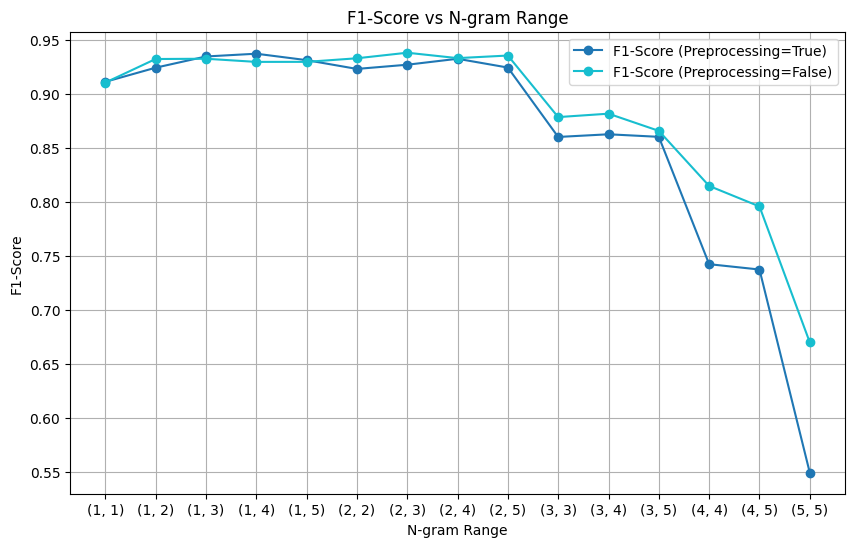

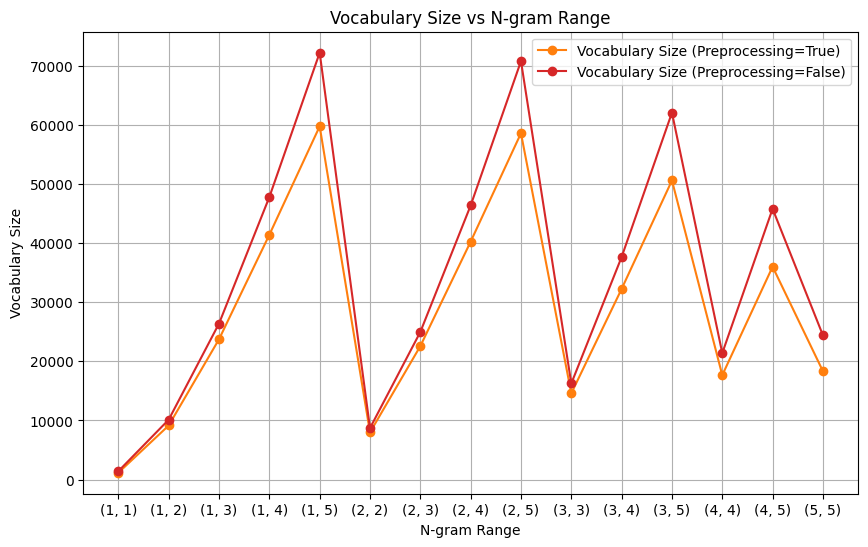

In [8]:
# Plot F1-scores
plt.figure(figsize=(10, 6))
plt.plot([str(r) for r in ngram_ranges], results[True]['f1_scores'], color='tab:blue', marker='o', label='F1-Score (Preprocessing=True)')
plt.plot([str(r) for r in ngram_ranges], results[False]['f1_scores'], color='tab:cyan', marker='o', label='F1-Score (Preprocessing=False)')
plt.xlabel('N-gram Range')
plt.ylabel('F1-Score')
plt.title('F1-Score vs N-gram Range')
plt.legend()
plt.grid()
plt.show()

# Plot Vocabulary Sizes
plt.figure(figsize=(10, 6))
plt.plot([str(r) for r in ngram_ranges], results[True]['vocab_sizes'], color='tab:orange', marker='o', label='Vocabulary Size (Preprocessing=True)')
plt.plot([str(r) for r in ngram_ranges], results[False]['vocab_sizes'], color='tab:red', marker='o', label='Vocabulary Size (Preprocessing=False)')
plt.xlabel('N-gram Range')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size vs N-gram Range')
plt.legend()
plt.grid()
plt.show()

### 1. F1-Score vs N-gram Range

- **What it shows:**  
  This plot displays the F1-score (a measure of classification performance) for different n-gram ranges, comparing results with and without text preprocessing.

- **How to read it:**  
  - The x-axis shows the n-gram range (e.g., (1,1) for unigrams, (1,2) for unigrams+bigrams, etc.).
  - The y-axis shows the F1-score (higher is better).
  - Two lines:  
    - Blue: Preprocessing applied  
    - Cyan: No preprocessing

- **Insights:**  
  - F1-score is highest for lower n-gram ranges and drops as n increases.
  - Preprocessing generally helps maintain a higher F1-score, especially as n-gram range increases.
  - Using very large n-grams leads to overfitting or data sparsity, reducing performance.

---

### 2. Vocabulary Size vs N-gram Range

- **What it shows:**  
  This plot shows how the vocabulary size (number of unique n-grams) grows with different n-gram ranges, for both preprocessing options.

- **How to read it:**  
  - The x-axis shows the n-gram range.
  - The y-axis shows the vocabulary size.
  - Two lines:  
    - Orange: Preprocessing applied  
    - Red: No preprocessing

- **Insights:**  
  - Vocabulary size increases rapidly as n-gram range increases.
  - Preprocessing reduces vocabulary size, making the model more efficient.
  - Very large vocabularies can lead to memory issues and overfitting.

---

**Summary:**  
- Lower n-gram ranges (e.g., unigrams, bigrams) give better F1-scores and manageable vocabulary sizes.
- Preprocessing improves both performance and efficiency.
- Using very large n-grams is not beneficial for this dataset.